In [13]:
# %load tensor.py
# 딥러닝 모델 관련 모듈
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense,Conv2D, UpSampling2D, BatchNormalization, Reshape, Flatten, Dropout
from tensorflow.keras.layers import Activation, LeakyReLU, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [23]:
#생성자 모델을 만듬
generator = Sequential()
generator.add(Dense(128 * 7 * 7, input_dim=100, activation=LeakyReLU(0.2))) # 노이즈 이미지 생성
generator.add(BatchNormalization())   # 데이터의 정규화 작업 : 분산 1, 평균 0
generator.add(Reshape((7,7 ,128)))   # Conv 에 입력 가능한 자료로 변환
generator.add(UpSampling2D())   # 이미지 확대 : 14 * 14 
generator.add(Conv2D(64, kernel_size=5, padding='same'))  # 14 * 14, size 변동 없음
generator.add(BatchNormalization())   # 데이터 정규화
generator.add(Activation(LeakyReLU(0.2)))   # 활성화 함수 는 leakyrelu 사용
generator.add((UpSampling2D()))    # 이미지 확댜 28 * 28
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))
generator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 6272)              633472    
                                                                 
 batch_normalization_3 (Batc  (None, 6272)             25088     
 hNormalization)                                                 
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        204864    
                                                                 
 batch_normalization_4 (Batc  (None, 14, 14, 64)      

In [24]:
# 판별자 모델 생성
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding='same')) # 14 * 14 * 64
discriminator.add(Activation(LeakyReLU(0.2)))  # 활성화 함수 지정
discriminator.add(Dropout(0.3))  # 30%  node 꺼줌
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same')) # 7 * 7 * 128
discriminator.add(Activation(LeakyReLU(0.2))) # 활성화 함수 지정
discriminator.add(Dropout(0.3)) # 30%  node 꺼줌   
discriminator.add(Flatten())  # 1차원으로 평탄화
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False   # 학습 기능 꺼줌 
discriminator.summary()
                  

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 conv2d_6 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 activation_4 (Activation)   (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 activation_5 (Activation)   (None, 7, 7, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                                 
 dense_6 (Dense)             (None, 1)                 6273      
          

In [25]:
# mnist 를 활용해서 CNN을 공부
from tensorflow.keras.datasets import mnist

(X_train, y_train), (_,_) = mnist.load_data()  # train, test 데이터로 분리해서 반환

X_train.shape


(60000, 28, 28)

In [26]:
import numpy as np

# 생성자와 판별자 모델을 연결시키는 모델 gan 생성
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_6 (Sequential)   (None, 28, 28, 1)         865281    
                                                                 
 sequential_7 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [27]:
# 학습하는 함수 생성
def gan_train(epoch, batch_size, saving_interval): 
    #  MNIST_data 불러오기
    (X_train, _), (_, _) = mnist.load_data()  # mnist 데이터셋에서 X_train 데이터만 사용하고자 함

    # conv2d를 사용하기 위해 3차원 배열로 shape 변환
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')  # 60000, 28, 28,1 의 형식
    
    # 각 픽셀의 값을 -1 ~ 1 로 변환 시킴 ( 활성화 함수 : tanh() 이므로 ): 0~ 255 사이의 값을 변환 시킴
    X_train = ( X_train - 127.5) / 127.5
    
    # batch_zise 만큼 참인 배열을 생성
    true = np.ones((batch_size, 1))   # shape(batch_size,1) 의 형식
    # fake 자료 생성
    fake = np.zeros((batch_size, 1))
    
    for i in range(epoch):
    # 60000개의 이미지 중 랜덤으로 batch_size 만큼의 자료를 추출
        idx = np.random.randint(0, X_train.shape[0], batch_size)  # 0 ~ 60000 개의 숫자중 bactch_size 만큼 정수 추출
        imgs = X_train[idx]  # 랜덤으로 이미지 추출
        d_loss_real = discriminator.train_on_batch(imgs, true)  # 레이블이 1인 자료 학습
        
        noise = np.random.normal(0, 1, (batch_size, 100))  # 생성자에 넣을 가상의 이미지 생성
        gen_imgs = generator.predict(noise)   # 가상의 이미지 
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        
        # 판별치의 오차 
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 
        # 생성자와 판별자를 연결해서 만든 모델 -> gan -> 오차를 구함 g_loss
        g_loss = gan.train_on_batch(noise, true)
        print(f'epoch : {epoch}   d_loss : {d_loss:.4f},  g_loss : {g_loss:.4f}')
        
        # 중간에 생성된 이미지 저장
        if i % saving_interval == 0:
            gen_idx = np.random.randint(0, len(gen_imgs), 25)  
            gen_show = gen_imgs[gen_idx] # 생성된 이미지를 랜덤으로 25개 추출           
            fig,axs = plt.subplots(5,5)
            count = 0
            for j in range(5):
                for k in range(5):
                    axs[j,k].imshow(gen_show[count, :, :, 0], cmap='Greys')
                    axs[j,k].axis('off')
                    count += 1
            fig.savefig("./data/gan_images/gan_mnist_{:d}.png".format(i))
    


1/1 [==============================] - 0s 46ms/step
epoch : 2001   d_loss : 0.4488,  g_loss : 1.8537
1/1 [==============================] - 0s 38ms/step
epoch : 2001   d_loss : 0.4166,  g_loss : 2.1048
1/1 [==============================] - 0s 38ms/step
epoch : 2001   d_loss : 0.6427,  g_loss : 1.5773
1/1 [==============================] - 0s 38ms/step
epoch : 2001   d_loss : 0.5692,  g_loss : 1.6429
1/1 [==============================] - 0s 41ms/step
epoch : 2001   d_loss : 0.5514,  g_loss : 1.4758
1/1 [==============================] - 0s 34ms/step
epoch : 2001   d_loss : 0.5720,  g_loss : 1.5230
1/1 [==============================] - 0s 38ms/step
epoch : 2001   d_loss : 0.6219,  g_loss : 1.8946
1/1 [==============================] - 0s 36ms/step
epoch : 2001   d_loss : 0.4174,  g_loss : 2.0710
1/1 [==============================] - 0s 40ms/step
epoch : 2001   d_loss : 0.5933,  g_loss : 2.0803
1/1 [==============================] - 0s 37ms/step
epoch : 2001   d_loss : 0.3950,  g_loss

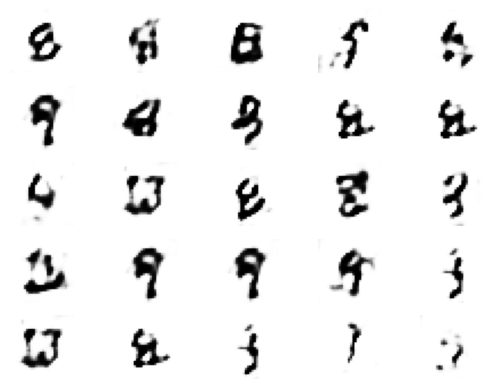

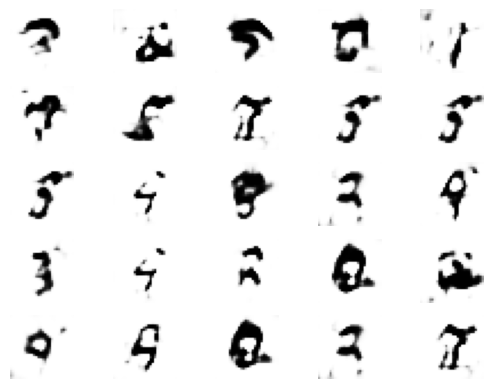

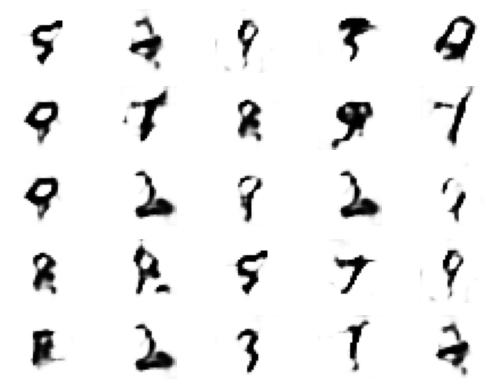

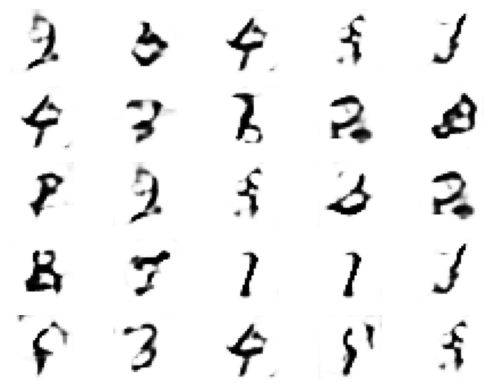

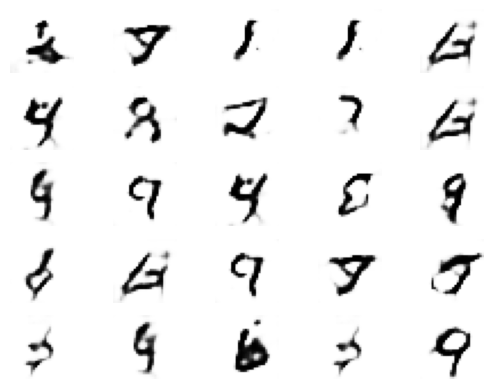

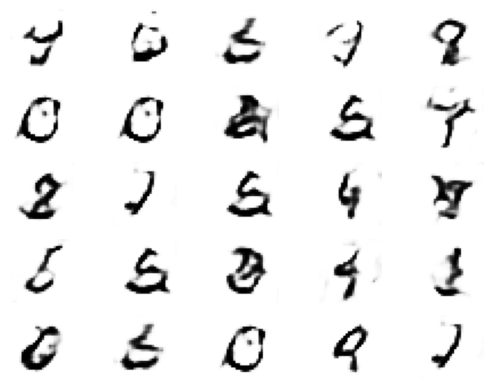

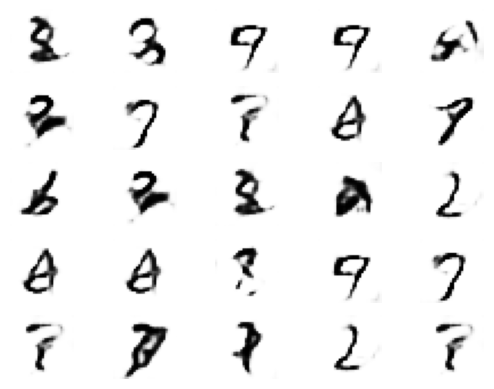

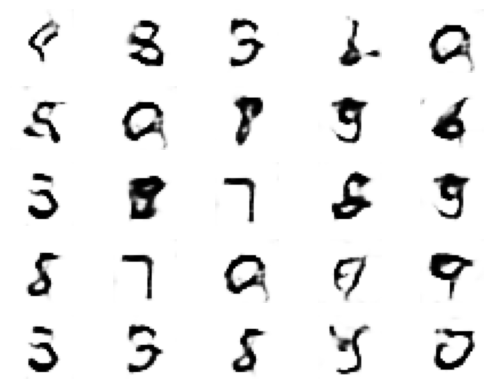

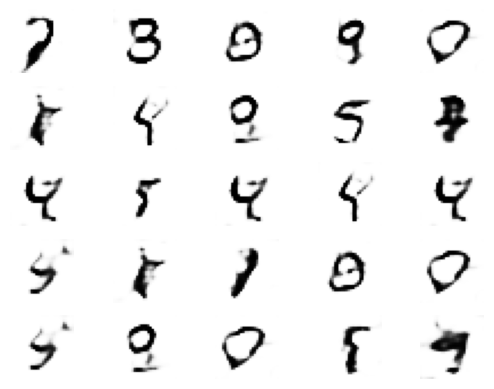

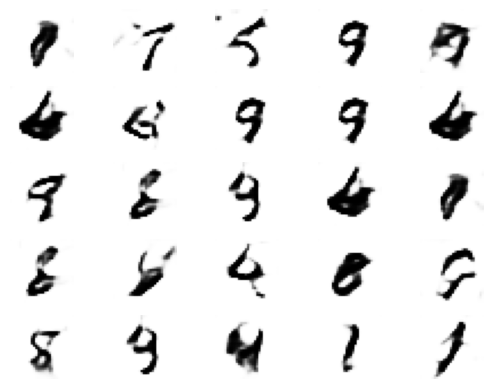

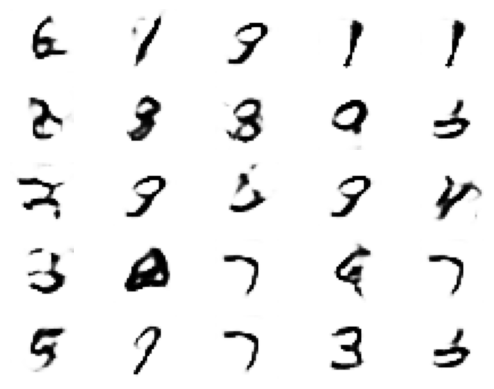

In [29]:
gan_train(2001,32,200)
